In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import pickle
import os
import math

plt.rc('font', size=10)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rc('legend', title_fontsize=10)
plt.rc('figure', titlesize=10)

plt.rc('legend', framealpha=0.0)
plt.rc('lines', linewidth=1.5)

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'
plt.rcParams['font.family'] = "Times New Roman"

matplotlib.rcParams['figure.figsize'] = (textwidth := 5.5, 2.0)
matplotlib.rcParams['figure.dpi'] = 150

colorize = lambda dim_list, colormap : [colormap(i) for i in np.linspace(0.0, 1.0, len(dim_list))]

plt.cm.plasma = matplotlib.colors.ListedColormap(plt.cm.plasma.colors[0:245])
plt.cm.viridis = matplotlib.colors.ListedColormap(plt.cm.viridis.colors[0:245])

In [3]:
def get_run(dataset, arch, optim, normalize, width, depth, key, average_last=1, verbose=False):
    logdir = os.path.join("..","logs",dataset,arch,optim,str(normalize),str(width),str(depth))        
    returned_result_list, returned_lr_list, args = [], [], {}
        
    for lr in 2.0 ** np.arange(-11,11):
        try:
            results = pickle.load(open(os.path.join(logdir, str(lr), 'results.pickle'), "rb"))[key]
            if verbose and len(results) < 10000: print("unfinished:", len(results), dataset, arch, optim, normalize, width, depth, lr)
            results = np.array(results)
            results = results[~np.isnan(results)]
            average_result = np.mean(results[-average_last:])
            returned_result_list.append(average_result)
            returned_lr_list.append(lr)
        except:
#             if verbose:
#                 print(f"warning: missing {dataset} {arch} {optim} {normalize} width={width} depth={depth} lr={lr}")
            pass
                
        if args == {}:
            try: args = pickle.load(open(os.path.join(logdir, str(lr), 'args.pickle'), "rb"))
            except: pass
    
    return returned_lr_list, returned_result_list, args

## Full sweeps

cifar10 rescnn


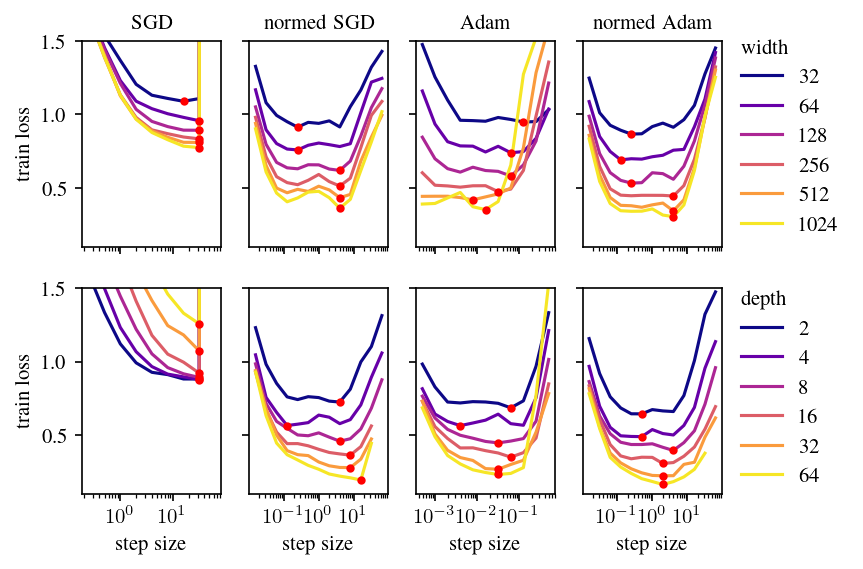

openwebtext gpt


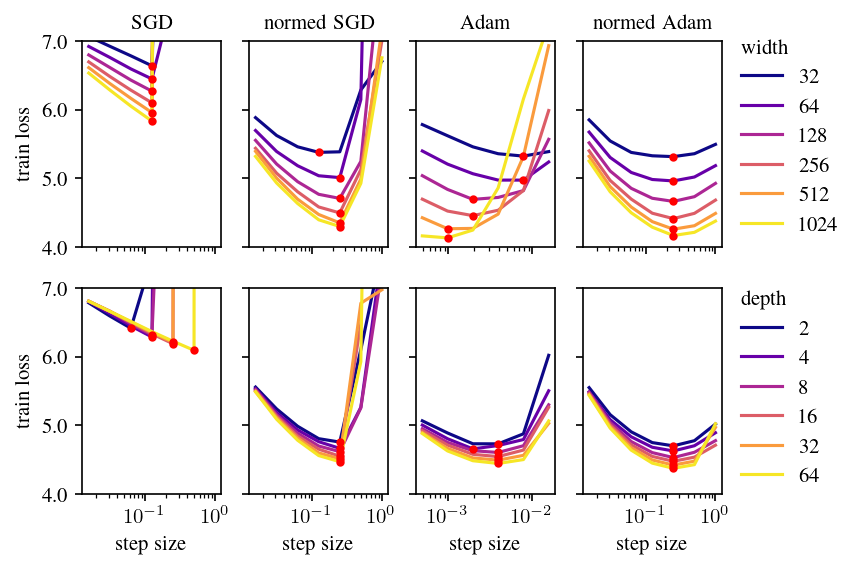

tinystories gpt


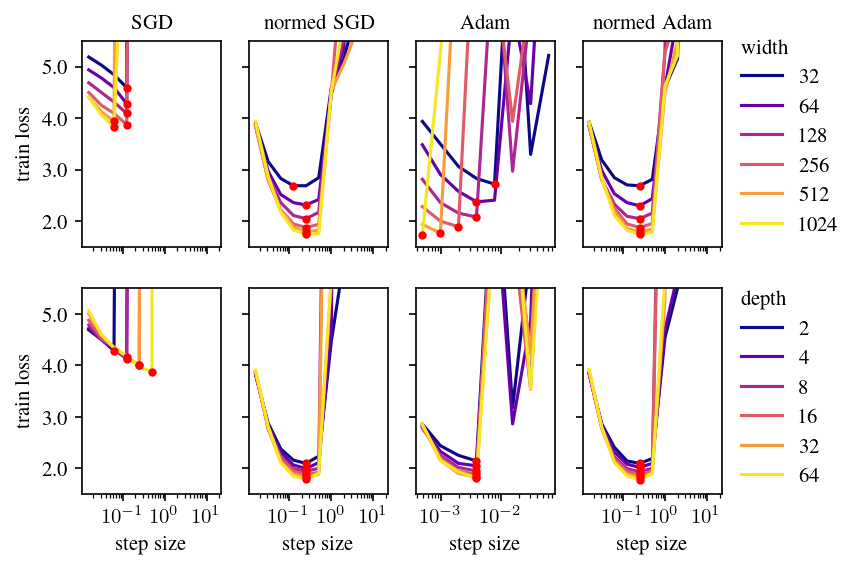

cifar10 resmlp


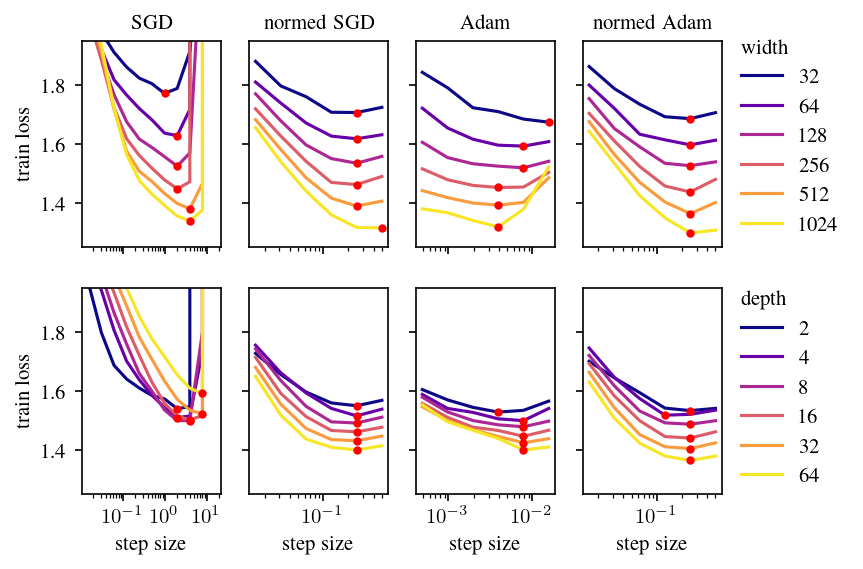

cifar10 rescnn


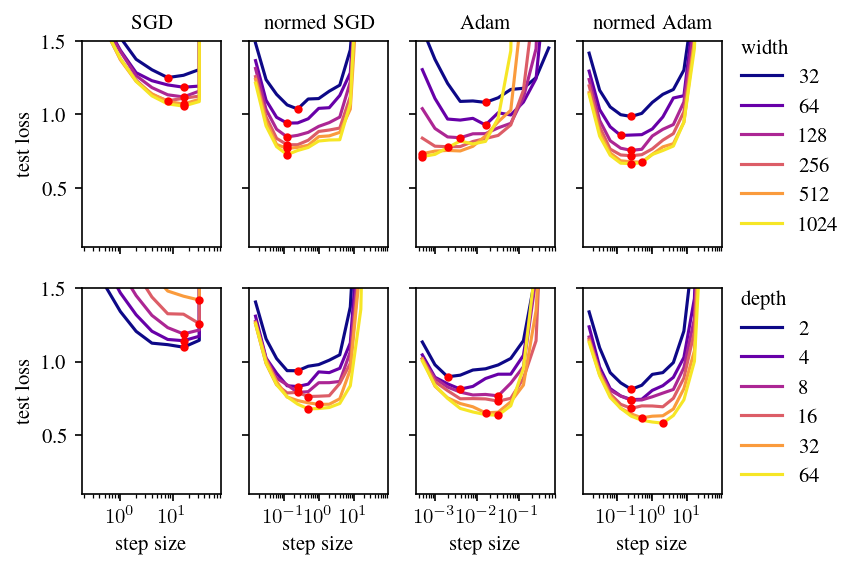

openwebtext gpt


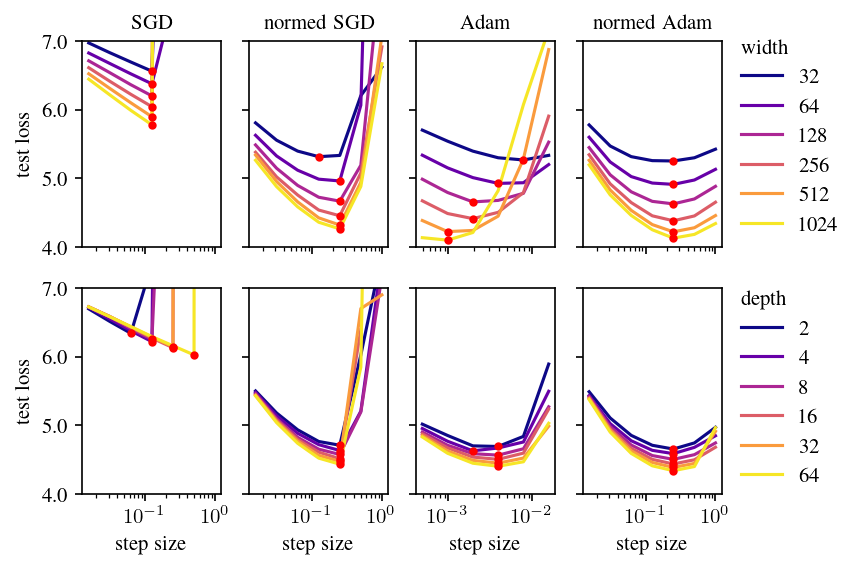

tinystories gpt


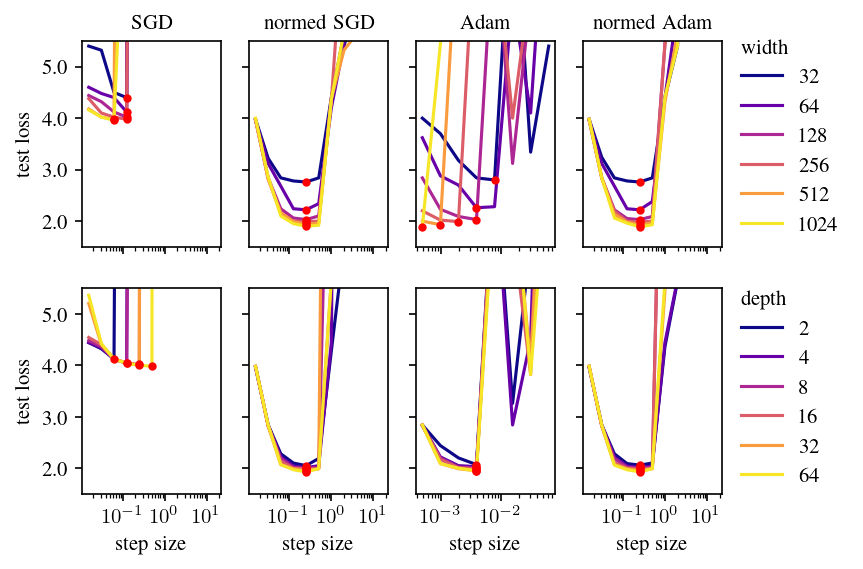

cifar10 resmlp


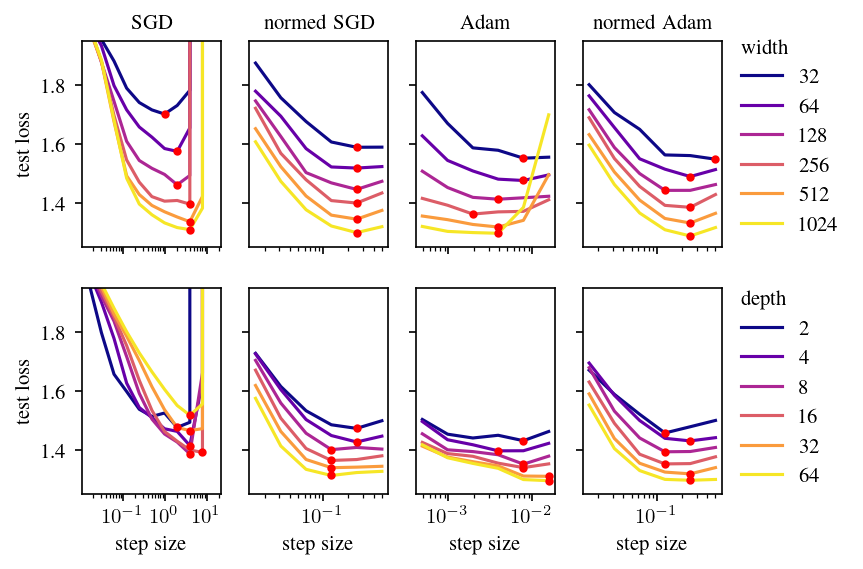

In [4]:
def truncate_axis_range(dataset, optim, normalize, arch, lr_list, result_list):
    start, end = 0, -1
    if dataset == "cifar10" and optim == "sgd" and not normalize and arch == "resmlp":
        start, end = 0, -4
    if dataset == "cifar10" and optim == "sgd" and not normalize and arch == "rescnn":
        start, end = 4, -2
    if dataset == "cifar10" and optim == "sgd" and normalize and arch == "rescnn":
        start, end = 0, -2
    if dataset == "cifar10" and optim == "adam" and normalize and arch == "rescnn":
        start, end = 0, -2
    if dataset == "cifar10" and optim == "adam" and not normalize and arch == "rescnn":
        start, end = 0, -3
    return lr_list[start:end], result_list[start:end]

def plot_sweeps(dataset, arch, key, ylim, average_last):

    width_list = [32, 64, 128, 256, 512, 1024]; this_depth = 3
    depth_list = [2, 4, 8, 16, 32, 64]; this_width = 128

    fig, axes = plt.subplots(2, 4, sharey=True)
    fig.set_figheight(4)

    axis = 0
    for optim in "sgd", "adam":
        for normalize in [0,1]:
            for width, color in zip(width_list, colorize(width_list, plt.cm.plasma)):
                lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width, this_depth, key, verbose=False, average_last=average_last)
                lr_list, result_list = truncate_axis_range(dataset, optim, normalize, arch, lr_list, result_list)
                axes[0,axis].plot(lr_list, result_list, color=color, label=width)
                if len(result_list) > 0 and not np.isnan(result_list).all():
                    min_idx = np.nanargmin(result_list)
                    axes[0,axis].plot(lr_list[min_idx], result_list[min_idx], 'o', markersize=3, color="red", zorder=100)
                axes[0,axis].set_xscale("log")
                axes[0,axis].set_xticklabels([])
                title = "SGD" if optim == "sgd" else "Adam"
                if normalize == 1: title = "normed " + title
                axes[0,axis].set_title(title)
            for depth, color in zip(depth_list, colorize(depth_list, plt.cm.plasma)):
                lr_list, result_list, args = get_run(dataset, arch, optim, normalize, this_width, depth, key, verbose=False, average_last=average_last)
                lr_list, result_list = truncate_axis_range(dataset, optim, normalize, arch, lr_list, result_list)                    
                axes[1,axis].plot(lr_list, result_list, color=color, label=depth)
                if len(result_list) > 0 and not np.isnan(result_list).all():
                    min_idx = np.nanargmin(result_list)
                    axes[1,axis].plot(lr_list[min_idx], result_list[min_idx], 'o', markersize=3, color="red", zorder=100)
                axes[1,axis].set_xscale("log")
                axes[1,axis].set_xlabel("step size")
            axis += 1
    if key == "train_loss": label = "train loss"
    if key == "test_loss":  label = "test loss"
    axes[0,0].set_ylabel(label)
    axes[1,0].set_ylabel(label)
    axes[0,0].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))


    axes[0,3].legend(title="width", bbox_to_anchor=(1.0, 1.10))._legend_box.align = "left"
    axes[1,3].legend(title="depth", bbox_to_anchor=(1.0, 1.08))._legend_box.align = "left"
    
    if ylim is not None:
        axes[0,0].set_ylim(ylim[0],ylim[1])

#     plt.tight_layout(pad=0, w_pad=0.5)
    plt.savefig(f"sweep-{dataset}-{arch}-{key}.pdf", bbox_inches='tight', pad_inches=0, facecolor='white', transparent=False)
    print(dataset, arch)
    plt.show()
    
plot_sweeps(dataset = "cifar10",     arch = "rescnn", key = "train_loss", ylim = (0.1,1.5),   average_last = 100 )
plot_sweeps(dataset = "openwebtext", arch = "gpt",    key = "train_loss", ylim = (4,7),       average_last = 1   )
plot_sweeps(dataset = "tinystories", arch = "gpt",    key = "train_loss", ylim = (1.5,5.5),       average_last = 1   )
plot_sweeps(dataset = "cifar10",     arch = "resmlp", key = "train_loss", ylim = (1.25,1.95), average_last = 50  )

plot_sweeps(dataset = "cifar10",     arch = "rescnn", key = "test_loss", ylim = (0.1,1.5),   average_last = 100 )
plot_sweeps(dataset = "openwebtext", arch = "gpt",    key = "test_loss", ylim = (4,7),       average_last = 1   )
plot_sweeps(dataset = "tinystories", arch = "gpt",    key = "test_loss", ylim = (1.5,5.5),       average_last = 1   )
plot_sweeps(dataset = "cifar10",     arch = "resmlp", key = "test_loss", ylim = (1.25,1.95), average_last = 50  )

## Figure 1: summary of GPT results

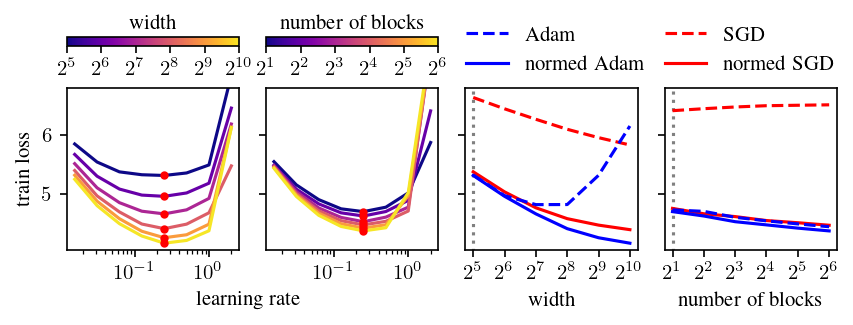

In [5]:
width_list = [32, 64, 128, 256, 512, 1024]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64]; this_width = 128

fig, axes = plt.subplots(1, 4, sharey=True)
fig.set_figheight(2)

axes = [axes[2], axes[3], axes[0], axes[1]]

key = "train_loss"
dataset = "openwebtext"
arch = "gpt"
avg = 1

for optim in ["sgd", "adam"]:
    opacity = 1.0
    color = "red" if optim=="sgd" else "blue"
            
    for normalize in [1,0]:
        linestyle = "solid" if normalize else "dashed"

        # get best lr at base width
        lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width=32, depth=this_depth, key=key, verbose=False, average_last=avg)
        min_idx = np.nanargmin(result_list)
        best_lr = lr_list[min_idx]

        best_results = []
        for width in width_list:
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width, depth=this_depth, key=key, verbose=False, average_last=avg)
            assert lr_list[min_idx] == best_lr, f"{lr_list[min_idx]} {best_lr}"
            result = result_list[min_idx]
            best_results.append(result)

        axes[0].plot(width_list, best_results, color=color, linestyle=linestyle)

        # get best lr at base depth
        lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width=this_width, depth=2, key=key, verbose=False, average_last=avg)
        min_idx = np.nanargmin(result_list)
        best_lr = lr_list[min_idx]

        best_results = []
        for depth in depth_list:
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width=this_width, depth=depth, key=key, verbose=False, average_last=avg)
            if False and len(lr_list) != 7:
                print("warning incomplete lr list")
                result = 10
            else:
                assert lr_list[min_idx] == best_lr, f"{lr_list[min_idx]} {best_lr}"
                result = result_list[min_idx]
            best_results.append(result)
        axes[1].plot(depth_list, best_results, color=color, linestyle=linestyle)

dataset = "openwebtext"
arch = "gpt"
optim = "adam"
normalize = 1

for width, color in zip(width_list, colorize(width_list, plt.cm.plasma)):
    lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width, this_depth, key, verbose=False)
    width_plot = axes[2].plot(lr_list, result_list, color=color, label=width)
    if len(result_list) > 0 and not np.isnan(result_list).all():
        min_idx = np.nanargmin(result_list)
        axes[2].plot(lr_list[min_idx], result_list[min_idx], 'o', markersize=3, color="red", zorder=100)
for depth, color in zip(depth_list, colorize(depth_list, plt.cm.plasma)):
    lr_list, result_list, args = get_run(dataset, arch, optim, normalize, this_width, depth, key, verbose=False)
    axes[3].plot(lr_list, result_list, color=color, label=depth)
    if len(result_list) > 0 and not np.isnan(result_list).all():
        min_idx = np.nanargmin(result_list)
        axes[3].plot(lr_list[min_idx], result_list[min_idx], 'o', markersize=3, color="red", zorder=100)

axes[0].set_xscale("log", base=2)
axes[1].set_xscale("log", base=2)
axes[0].set_xticks(width_list)
axes[1].set_xticks(depth_list)

axes[0].set_xlabel("width")
axes[1].set_xlabel("number of blocks")

axes[2].set_ylabel("train loss")

axes[2].set_xscale("log")
axes[3].set_xscale("log")
axes[2].set_xlabel("learning rate")
axes[2].xaxis.set_label_coords(x=1.05, y=-0.255)

cbar1 = fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.SymLogNorm(vmin=width_list[0], vmax=width_list[-1], base=2, linthresh=0.001), cmap=plt.cm.plasma), ax=axes[2], location='top', pad=0.175, label="width")
cbar2 = fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.SymLogNorm(vmin=depth_list[0], vmax=depth_list[-1], base=2, linthresh=0.001), cmap=plt.cm.plasma), ax=axes[3], location='top', pad=0.175, label="number of blocks")
cbar3 = fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.SymLogNorm(vmin=width_list[0], vmax=width_list[-1], base=2, linthresh=0.001), cmap=plt.cm.plasma), ax=axes[0], location='top', pad=0.175, label="width")
cbar4 = fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.SymLogNorm(vmin=depth_list[0], vmax=depth_list[-1], base=2, linthresh=0.001), cmap=plt.cm.plasma), ax=axes[1], location='top', pad=0.175, label="number of blocks")

cbar1.ax.xaxis.set_ticks_position('bottom')
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar3.ax.xaxis.set_ticks_position('bottom')
cbar4.ax.xaxis.set_ticks_position('bottom')

cbar3.ax.set_visible(False)
cbar4.ax.set_visible(False)

handles = []
handles.append(mlines.Line2D([], [], color='blue', linestyle='dashed', label='Adam'))
handles.append(mlines.Line2D([], [], color='blue', linestyle='solid',  label='normed Adam'))
handles.append(mlines.Line2D([], [], color='red',  linestyle='dashed', label='SGD'))
handles.append(mlines.Line2D([], [], color='red',  linestyle='solid',  label='normed SGD'))
axes[0].legend(handles=handles, ncol=2, loc="upper center", bbox_to_anchor=(1.07,1.5), columnspacing=1.0).set_in_layout(False)

axes[2].set_ylim(4.05,6.8)

axes[0].vlines(x = 32, ymin = 0, ymax = 10, linestyle='dotted', color = 'gray', zorder=-100)
axes[1].vlines(x = 2, ymin = 0, ymax = 10, linestyle='dotted', color = 'gray', zorder=-100)

plt.tight_layout(pad=0, w_pad=0.2)
plt.savefig("aggregate.pdf", bbox_inches='tight', pad_inches=0, facecolor='white', transparent=False)
plt.show()

## Figure 4: aggregates across tasks

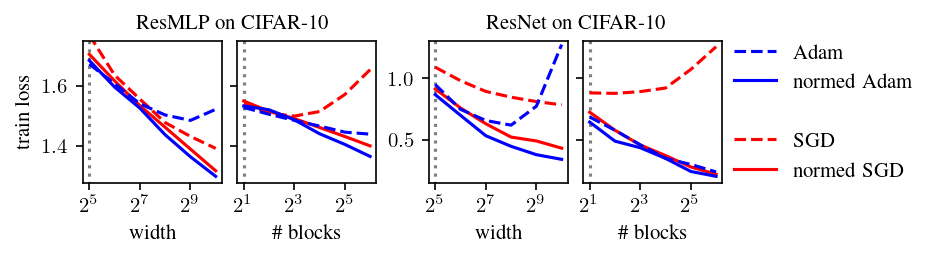

In [6]:
width_list = [32, 64, 128, 256, 512, 1024]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64]; this_width = 128

fig, axes = plt.subplots(1, 4)
fig.set_figheight(1.25)

key = "train_loss"

for dataset, arch, avg, ax_offset in [("cifar10", "resmlp", 50, 0), ("cifar10", "rescnn", 100, 2)]:

    for optim in ["sgd", "adam"]:
        opacity = 1.0
        color = "red" if optim=="sgd" else "blue"

        for normalize in [1,0]:
            linestyle = "solid" if normalize else "dashed"

            # get best lr at base width
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width=32, depth=this_depth, key=key, verbose=False, average_last=avg)
            min_idx = np.nanargmin(result_list)
            best_lr = lr_list[min_idx]

            best_results = []
            for width in width_list:
                lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width, depth=this_depth, key=key, verbose=False, average_last=avg)
                assert lr_list[min_idx] == best_lr, f"{lr_list[min_idx]} {best_lr}"
                result = result_list[min_idx]
                best_results.append(result)

            axes[ax_offset + 0].plot(width_list, best_results, color=color, linestyle=linestyle)

            # get best lr at base depth
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width=this_width, depth=2, key=key, verbose=False, average_last=avg)
            min_idx = np.nanargmin(result_list)
            best_lr = lr_list[min_idx]

            best_results = []
            for depth in depth_list:
                lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width=this_width, depth=depth, key=key, verbose=False, average_last=avg)
                if False and len(lr_list) != 7:
                    print("warning incomplete lr list")
                    result = 10
                else:
                    assert lr_list[min_idx] == best_lr, f"{lr_list[min_idx]} {best_lr}"
                    result = result_list[min_idx]
                best_results.append(result)
            axes[ax_offset + 1].plot(depth_list, best_results, color=color, linestyle=linestyle)

axes[0].set_xscale("log", base=2)
axes[1].set_xscale("log", base=2)
axes[2].set_xscale("log", base=2)
axes[3].set_xscale("log", base=2)

alternate = lambda l : [l[i] for i in range(len(l)) if i % 2 == 0]

axes[0].set_xticks(alternate(width_list))
axes[1].set_xticks(alternate(depth_list))
axes[2].set_xticks(alternate(width_list))
axes[3].set_xticks(alternate(depth_list))

axes[0].set_xlabel("width")
axes[1].set_xlabel("\# blocks")
axes[2].set_xlabel("width")
axes[3].set_xlabel("\# blocks")

axes[0].set_ylabel("train loss")

axes[0].set_ylim(1.275,1.75)
axes[1].set_ylim(1.275,1.75)
axes[2].set_ylim(0.15,1.3)
axes[3].set_ylim(0.15,1.3)

axes[1].set_yticklabels([])
axes[3].set_yticklabels([])

axes[0].set_title("ResMLP on CIFAR-10", loc="left", x=0.38)
axes[2].set_title("ResNet on CIFAR-10", loc="left", x=0.41)

handles = []
handles.append(mlines.Line2D([], [], color='blue', linestyle='dashed', label='Adam'))
handles.append(mlines.Line2D([], [], color='blue', linestyle='solid',  label='normed Adam'))
handles.append(mlines.Line2D([], [], color='none', linestyle='solid',  label=''))
handles.append(mlines.Line2D([], [], color='red',  linestyle='dashed', label='SGD'))
handles.append(mlines.Line2D([], [], color='red',  linestyle='solid',  label='normed SGD'))
axes[3].legend(handles=handles, ncol=1, loc="right", bbox_to_anchor=(2.5,0.5), columnspacing=1.0)

# plt.tight_layout(pad=0, w_pad=0.2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
pos1 = axes[1].get_position()
axes[1].set_position([pos1.x0 - 0.015, pos1.y0, pos1.width, pos1.height])
pos2 = axes[2].get_position()
axes[2].set_position([pos2.x0 + 0.015, pos2.y0, pos2.width, pos2.height])

axes[0].vlines(x = 32, ymin = 0, ymax = 3, linestyle='dotted', color = 'gray', zorder=-100)
axes[1].vlines(x = 2, ymin = 0, ymax = 3, linestyle='dotted', color = 'gray', zorder=-100)
axes[2].vlines(x = 32, ymin = 0, ymax = 3, linestyle='dotted', color = 'gray', zorder=-100)
axes[3].vlines(x = 2, ymin = 0, ymax = 3, linestyle='dotted', color = 'gray', zorder=-100)

plt.savefig("tasks.pdf", bbox_inches='tight', pad_inches=0, facecolor='white', transparent=False)
plt.show()